# Extremium Seeking Control

This notebook demonstrates extremium seeking applied to a function which is a static map of a single input parameter to a single output parameter.  

## Requirements

Requires a later version of Python which supports the control package with non-linear systems support (nlsys function). 

## Introduction

Extremium seeking control is an algorithm which optimizes a parameter  to a function in order to maximise the resultant value of that function.

For example, a function in this case could be a second order polynomial such as an inverted parabola:

$$f(x)=4-(x-2)^2 \tag{1.1}$$

The maximum value of this function is 4, which occurs when the parameter $x$ is equal to 2, as shown below.


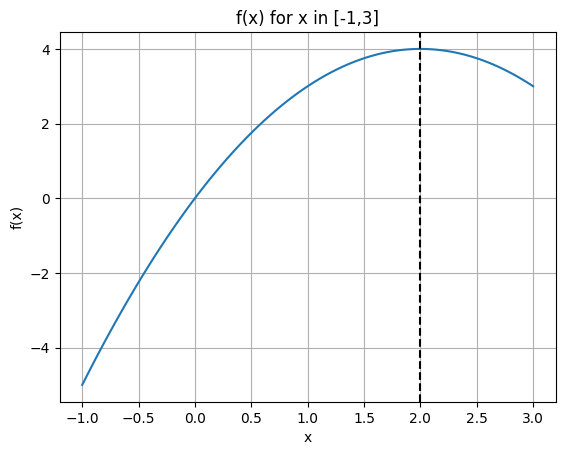

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import control as ct

# Define an inverted parabola function
def f(x):
    return 4 - (x-2)**2

# Values of x to plot the function for
x = np.linspace(-1,3, num=100)

# Plot the function
plt.plot(x, f(x))
plt.grid()
plt.ylabel("f(x)")
plt.xlabel("x")
plt.title("f(x) for x in [-1,3]")
plt.axvline(2, linestyle="--", color="k")



An extremium seeking control algorithm would attempt to find the input parameter value of 2 which produces the maximal output of 4. 



# Extremium Seeking Algorithm

Extremium seeking control is a type of gradient ascent algorithm and has been extensively studied [1] [2]. The algorithm maximises the value of an objective function by adjusting a parameter of the function in the direction of the parameter's  gradient. To do this, a perturbation is introduced into the parameter. Coherent de-modulation is then used to obtain an estimate of the function's gradient from the resulting perturbation in the function value. The objective function may be a static map or a dynamic system, and should have extremum for which we are trying to optimize the parameter.

A block diagram of an extremium seeking control algorithm is shown below. In this case the notation for signals in [2] has been used.

<div>
<img src="images/extremium-seeking-no-filter-block-diagram.png" width="50%"/>
</div>

Where:
* $\theta$ - instantaneous value of function parameter.
* $\hat{\theta}$ - estimate of the parameter associated with the extremum.
* $y$ - function output.
* $\xi$ - de-modulated function output.
* $k$ - learning rate.
* $a$ - amplitiude of perturbation used for modulation.
* $\omega$ - frequency of peturbation, in radians per second

## Modulation

The purpose of the modulation block is to introduce the perturbation signal to the functions's parameter. This is achieved by the summation block, which sums the estimated parameter $\hat{\theta}$ from the output of the integration block and the scaled perturbation signal $a sin(\omega t)$:

$$ \theta = \hat{\theta} + a sin(\omega t)$$

A design parameter, $a$, determines the amplitude of the purturbation applied to the paramter.

## De-modulation and Estimate of $f'(\hat{\theta})$

The de-modulation block recovers information on the gradient from the output signal. De-modulation is achieved by the high-pass filter, which removes the unwanted DC component, and the multiplication function which when applied to the perturbation in the output recovers the signal at the purturbation frequency. The low-pass filter then averages the de-modulated signal reducing the AC component.

Using a first-order taylor expansion of the function we can show that the derivative of the function can be inferred from demodulation of the perturbation present in the function's output [3].  

The first-order Taylor expansion of some function $f(x)$ near some operating point $a$ is an a approximation in the form:

$$f(x) \approx f(a) + f'(a)(x-a)$$

Here $x$ is the parmeter of the function and $a$ is some operating point which we linearize the function about. The first order derivative of the function is given by $f'(.)$. 

For our generalised static extremium-seeking problem we will define the operating point to be the parameter estimate, $\hat{\theta}$, and the parameter as the instenanteous $\theta$ which the perturbation is centered about. Provided the perturbation magnitude $\omega$ is sufficiently small such that the linearised function is a good approximation we have:

$$f(\theta) \approx f(\hat{\theta}) + f'(\hat{\theta}) \left[ \theta-\hat{\theta} \right] \tag{2.1}$$

Next, from the control diagram we observe that $\theta = \hat{\theta} + a sin(\omega t)$, and making the substitution results in elimination of $\hat{\theta}$:

$$f(\theta) \approx f(\hat{\theta}) + f'(\hat{\theta}) \left[ a sin(\omega t) \right] \tag{2.2}$$

Multiplying by $sin(\omega t)$ at the input to the gain block results in an expression for the de-modulated signal $\xi$:

$$\xi \approx f(\hat{\theta}) sin(\omega t) + f'(\hat{\theta}) \left[ a sin^2(\omega t) \right] $$

And on using the trigonometric identity $sin^2(x) = \frac{1}{2} - \frac{1}{2} cos(2x)$:

$$\xi \approx f(\hat{\theta}) sin(\omega t) + f'(\hat{\theta}) \frac{a}{2} - f'(\hat{\theta}) \frac{a}{2} cos(2 \omega t) \tag{2.3}$$

This is a coherent de-modulating process which works in the same way as a synchronous detector. We note here the first term is a difference frequency ($f'(\hat{\theta}) \frac{a}{2}$) where the signal containing the derivitive information is shifted to DC. A sum frequency ($- f'(\hat{\theta}) \frac{a}{2} cos(2 \omega t)$) is also present which is shifted to twice the perturbation frequency. 

Graphically this can be illustrated by considering the AC perturbation in the function's input and output. For example, in the plot below the function is monotonic increasing over the region of the domain corresponding to the input perturbation. The zero crossing points of the two signals are therefore in-phase, and the product of these components is will be greater than or equal to zero. This product signal is composed of the sum and difference frequencies described previously.


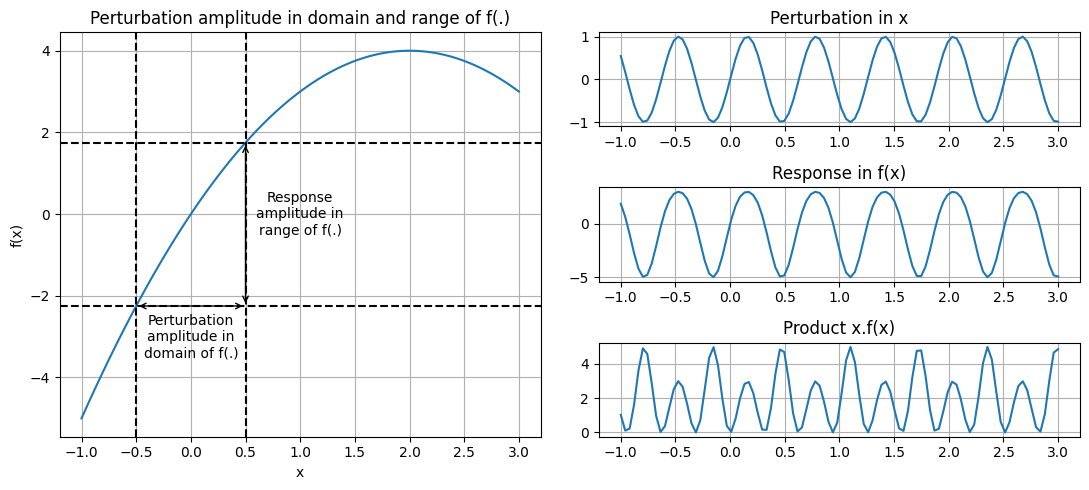

In [9]:
def plotPerturbation(f, x1, x2, xPert1, xPert2):

    # Values of x to plot the function for
    x = np.linspace(x1, x2, num=100)
    
    # Plot the function
    plt.figure(figsize=(11,5))
    plt.subplot(1,2,1)
    plt.plot(x, f(x))
    plt.grid()
    plt.ylabel("f(x)")
    plt.xlabel("x")
    plt.title("Perturbation amplitude in domain and range of f(.)")
    plt.axvline(xPert1, linestyle="--", color="k")
    plt.axvline(xPert2, linestyle="--", color="k")
    
    # Annotate parts of the domain and range of the function
    plt.axhline(f(xPert1), linestyle="--", color="k")
    plt.axhline(f(xPert2), linestyle="--", color="k")
    plt.annotate('', xy=(xPert2, f(xPert1)), xytext=(xPert2,f(xPert2)), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('', xy=(xPert1, f(xPert1)), xytext=(xPert2,f(xPert1)), arrowprops=dict(arrowstyle='<->'))
    plt.text((xPert1+xPert2)/2, min(f(xPert1),f(xPert2))-0.2, "Perturbation\namplitude in\ndomain of f(.)", ha="center",  va="top")
    plt.text((x1+x2)/2, -0.5, "Response\namplitude in\nrange of f(.)", ha="center")
    
    # Plot the perturbation
    plt.subplot(3,2,2)
    plt.title("Perturbation in x")
    plt.plot(x, np.sin(x*10))
    plt.grid()
    
    # Plot the response
    plt.subplot(3,2,4)
    plt.title("Response in f(x)")
    plt.plot(x, f(np.sin(x*10)+(xPert2+xPert1)/2))
    plt.grid()
    
    # Plot the product of the perturbation and response
    plt.subplot(3,2,6)
    plt.title("Product x.f(x)")
    plt.plot(x, np.sin(x*10)*f(np.sin(x*10)+(xPert2+xPert1)/2))
    plt.grid()
    
    # Improve layout
    plt.tight_layout()

    return

# Show signals for monotonic increasing
plotPerturbation(f, -1, 3, -0.5, 0.5)



If the function is monotonic decreasing for the perturbation in the input signel then the perturbation in the output will be out-of-phase. Refering to the figure below, considering only the AC components in the function's input and output, we can see that the product is a negative value less than or equal to zero. The negative derivative would be used to update the paraemter estimate in the reverse direction towards the extremum. Eventually, an equilibirium will be reached at the maximal value of the function where the derivative and it's estimate is zero. 


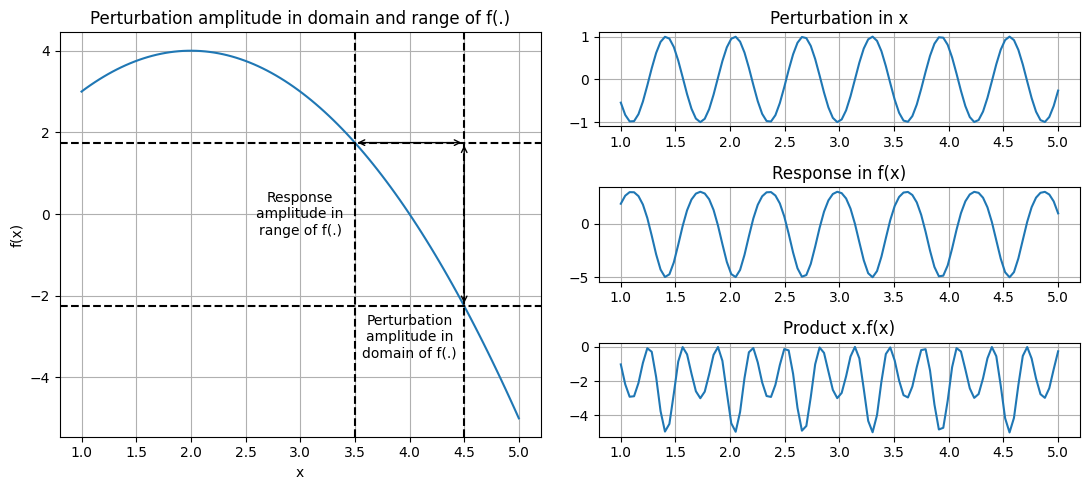

In [3]:
# Show signals for monotonic decreasing
plotPerturbation(f, 1, 5, 3.5, 4.5)



Accordingly, it is the derivative information in the DC signal component of (2.3) which is of interest, and must be recovered from $\xi$. We could apply filtering to directly remove the higher frequency components, however in extremium seeking without explicit filtering this can is done by integration of $\xi$. This works as the average value of a periodic signal is zero when averaged over a sufficient time $T$, with explanation as follows.

## Parameter Update by Integration of $f'(\hat{\theta})$

The integrator block produces an estimate of the parameter by integrating the inferred derivative signal from the output of the de-modulation block. As long as the derivative signal is non-zero the optimal parameter estimate will continuously be updated towards the true optimal parameter. The gain $k$ at the input of the integrator block is the learning rate and determines how fast $\hat{\theta}$ is updated. 

Refering to (2.3), the integrated signal as steady-state can be evaluated as a sum of limits as the averaging time $T$ approaches $\infty$:

$$ \xi_{SS} \approx \lim_{T \to \infty} \frac{1}{T} \int_{0}^{T} k \xi dt $$
$$ \xi_{SS} \approx k f(\hat{\theta}) \lim_{T \to \infty} \left[ \frac{1}{T} \int_{0}^{T} sin(\omega t) dt \right] + \frac{a k}{2} f'(\hat{\theta}) \lim_{T \to \infty} \left[ \frac{1}{T} \int_{0}^{T} 1 dt \right] - \frac{a k}{2} f'(\hat{\theta}) \lim_{T \to \infty} \left[ \frac{1}{T} \int_{0}^{T} cos(2 \omega t) dt \right] \tag{2.4}$$

For the limit in the first term of (2.4), the definite integral and limit evaluates as:

$$ \lim_{T \to \infty} \left[ \frac{1}{T} \int_{0}^{T} sin(\omega t) dt \right] = \lim_{T \to \infty} \left[ \frac{1}{\omega T} - \frac{cos(\omega T)}{\omega T} \right] = \frac{1}{\omega \times \infty} - \frac{cos(\omega \times \infty)}{\omega \times \infty} = 0$$

Here we see that the cosine function in the numerator is bounded at $\pm 1$, while the denominators are unbounded and free to approach infinity, resulting in a limit of zero which eliminates these terms from (2.4).

For the limit in the second term of (2.4), the definite integral and limit evaluates as:

$$ \lim_{T \to \infty} \left[ \frac{1}{T} \int_{0}^{T} 1 dt \right] = \lim_{T \to \infty} \left[ \frac{T}{T} \right] = \frac{\infty}{\infty} = 1$$

Here the limit evalutes to a finite number (1) and the term is preserved in $\xi_{SS}$.

For the limit in the third term of (2.4), the definite integral and limit evaluates as:

$$ \lim_{T \to \infty} \left[ \frac{1}{T} \int_{0}^{T} cos(2 \omega t) dt \right] = \lim_{T \to \infty} \left[ \frac{sin(2 \omega T)}{2 \omega T} - \frac{0}{2 \omega T} \right] = \frac{sin(2 \omega \infty)}{2 \omega \infty} = 0$$

Here, similar to the case previously, we see that the sine function is bounded at $\pm 1$ while the demoninator is unbounded and free to approach infinity, resulting in a limit of zero eliminating the term from (2.4).

Substituting these results into (2.4) leads to an extression for $\xi_{SS}$:

$$ \xi_{SS} \approx \frac{a k}{2} f'(\hat{\theta}) \tag{2.5}$$

This result shows that through de-modulation and integration we obtain an estimate of the function's derivative and is the mechanism by which extremium seeking control works.


## Filtering to Reduce Perturbation in $\hat{\theta}$

Filtering can be used to reduce unwanted oscillation in $\hat{\theta}$ due to the perturbation signal. A block diagram of an extremium seeking control algorithm with filtering in the demodulation block is shown below. In this case a high-pass filter is applied at the input to the de-modulation block to remove the DC component. Low pass filtering is also applied at the output of the de-modulation block to remove the unwanted high frequency signal created in the de-modulation process. 

<div>
<img src="images/extremium-seeking-block-diagram.png" width="50%"/>
</div>

Where:
* $\omega_h$ is the high pass cutoff frequency, in radians per second.
* $\omega_l$ is the low pass cutoff frequency, in radians per second.

In designing the high-pass filter we require minimial attenuation to the perturbation frequency while blocking DC ($ \omega_{HP} < \omega $). We also require for the low-pass filter minimal attenuatuation to the DC gradient information while rejecting unwanted signals at the perturbation frequency (i.e. $\omega_{LP} < \omega$) [4].

In designing the filter it is also important to compensate for any effects of the phase-delay introduced by the filter transfer functions.

Let $G_{HP}(\omega)$ represent the gain of the high-pass filter at frequency $\omega$ and $\phi_{HP}(\omega)$ the phase offset introduced. 

Starting from (2.2), we apply the gain and phase offset from the high-pass filter prior to de-modulation:

$$f_{HP}(\theta) \approx  G_{HP}(0) f(\hat{\theta}) + G_{HP}(\omega) f'(\hat{\theta}) \left[ a sin(\omega t + \phi_{HP}(\omega)) \right] \tag{2.6}$$

Then, multiplying by $sin(\omega t)$ to de-modulate the perturbation signal:  

$$f_{DM}(\theta) \approx  G_{HP}(0) f(\hat{\theta}) sin(\omega t) + G_{HP}(\omega) f'(\hat{\theta}) \left[ a sin(\omega t + \phi_{HP}(\omega)) sin(\omega t) \right] \tag{2.7}$$

And applying the identity $sin(A)sin(B) = \frac{1}{2}cos(A-B) - \frac{1}{2}cos(A+B)$, the expression becomes:

$$f_{DM}(\theta) \approx  G_{HP}(0) f(\hat{\theta}) sin(\omega t) + G_{HP}(\omega) a f'(\hat{\theta}) \left[  \frac{1}{2}cos \left( \omega t + \phi_{HP} - \omega t \right) - \frac{1}{2}cos \left( \omega t + \phi_{HP}(\omega) + \omega t \right) \right] \tag{2.8}$$

$$f_{DM}(\theta) \approx  G_{HP}(0) f(\hat{\theta}) sin(\omega t) + \frac{G_{HP}(\omega) a f'(\hat{\theta})}{2}cos \left( \phi_{HP}(\omega) \right) - \frac{G_{HP}(\omega) a f'(\hat{\theta})}{2}cos \left( 2\omega t + \phi_{HP}(\omega) \right) \tag{2.9}$$

From this result we can see that the second term containing the gradient information is attenuated not just by the magnitude response of the high-pass filter, $G_{HP}(\omega)$, but also by the phase response in $cos(\phi_{HP}(\omega))$. We can compensate for this by introducing a phase delay into the de-modulation signal. Let $\theta_DM$ be a phase delay introduced to the de-modulation signal. 

Multiplying (2.6) by $sin(\omega t + \phi_DM)$, then using the same identity as before, the expression for the output of the de-modulation block then becomes:

$$f_{DM}(\theta) \approx  G_{HP}(0) f(\hat{\theta}) sin(\omega t + \phi_{DM}) + G_{HP}(\omega) f'(\hat{\theta}) \left[ a sin(\omega t + \phi_{HP}(\omega)) sin(\omega t + \phi_DM) \right] \tag{2.10}$$

$$f_{DM}(\theta) \approx  G_{HP}(0) f(\hat{\theta}) sin(\omega t + \phi_{DM}) + G_{HP}(\omega) a f'(\hat{\theta}) \left[  \frac{1}{2}cos \left( \omega t + \phi_{HP}(\omega) - \omega t - \phi_{DM} \right) - \frac{1}{2}cos \left( \omega t + \phi_{HP}(\omega) + \omega t + \phi_{DM} \right) \right] \tag{2.11}$$

$$f_{DM}(\theta) \approx  G_{HP}(0) f(\hat{\theta}) sin(\omega t + \phi_{DM}) + \frac{G_{HP}(\omega) a f'(\hat{\theta})}{2}cos \left( \phi_{HP}(\omega) - \phi_{DM} \right) - \frac{G_{HP}(\omega) a f'(\hat{\theta})}{2}cos \left( 2 \omega t + \phi_{HP}(\omega) + \phi_{DM} \right) \tag{2.12}$$

From this we can see that if we set the de-modulation phase delay, $\phi_{DM}$, to be equal to $\phi_{HP}(\omega)$, the phase response of the high-pass filter at $\omega$, we can cancel the attenuation introduced due to phase delay in the high-pass filter.

Next we will let $G_{LP}(\omega)$ be the gain of the low-pass filter, for some frequency $\omega$, and $\phi_{LP}(\omega)$ the phase response. Applying this to (2.12) results in an expression for the filtered de-modulated signal:

$$\xi \approx  G_{LP}(\omega) G_{HP}(0) f(\hat{\theta}) sin(\omega t + \phi_{DM} + \phi_{LP}(\omega)) + \frac{G_{LP}(0) G_{HP}(\omega) a f'(\hat{\theta})}{2}cos \left( \phi_{HP}(\omega) - \phi_{DM} \right) - \frac{G_{LP}(2 \omega) G_{HP}(\omega) a f'(\hat{\theta})}{2}cos \left( 2 \omega t + \phi_{HP}(\omega) + \phi_{DM} + \phi_{LP}(2 \omega) \right) \tag{2.13}$$

Since we expect $G_{HP}(0)$ to be very small, the first term is effectively removed in the high-pass filter stage. Likewise as we expect $2 \omega >> \omega_LP$,  the $G_{LP}(2 \omega)$ would be small and the third term is removed in the low-pass filter stage. This leaves the DC second term in (2.13) as the input to the integration stage. 

$$\xi \approx \frac{G_{LP}(0) G_{HP}(\omega) a f'(\hat{\theta})}{2}cos \left( \phi_{HP}(\omega) - \phi_{DM} \right) \tag{2.14}$$

The removal of periodic signals presenting to the integration stage greatly reduces the oscillation in, $\hat{\omega}$, the estimated parameter. 


# Applying to a Static Function

In the example below, extremium seeking without filtering has been applied to the parabolic function described in the input to this notebook. In this case, with the parameters used convergence is achieved in approximately 500 seconds. However, there is significant oscillation in $\hat{\theta}$ of approximately 0.2 in peak-to-peak magnitude. 


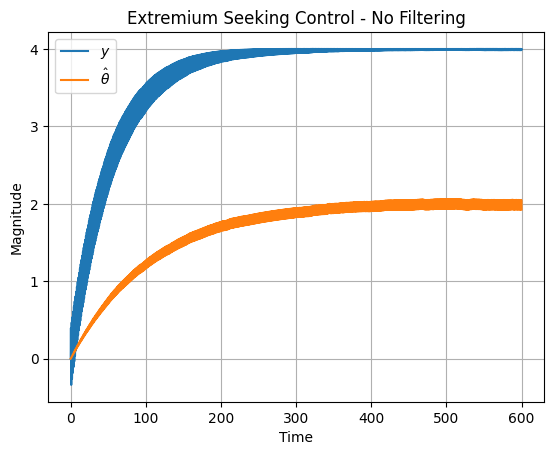

In [135]:
# Parameters 
omega = 2*np.pi # Should be within pass-band of both filters
k = 0.1 # Gain is learning rate
a = 0.1 # Gain on perturbation added to parameter

# Define our function to find the extremium for
def f_upd(t, x, u, params):
    return 0

def f_out(t, x, u, params):
    return 4 - (u[0]-2)**2

# Create our function block
f_sys = ct.nlsys(f_upd, f_out, states='x', inputs='theta', outputs='y')

# Create parameter update block
integrator_sys = ct.tf([1],[1,0]) # Create an integrator
gain_sys = ct.tf([k],[1]) # Create a gain block
update_sys = ct.series(integrator_sys, gain_sys, inputs='y3', outputs='theta_hat')

# Create the modulation summing junction
modulation_sys = ct.summing_junction(inputs=['theta_hat', 'r1'], output='theta')

def multiply_upd(t, x, u, params):
    return 0
def multiply_out(t, x, u, params):
    return u[0]*u[1]
demodulation_sys = ct.nlsys(multiply_upd, multiply_out, states='x', inputs=['y', 'r2'], outputs='y3')

T = ct.interconnect([f_sys, update_sys, modulation_sys, demodulation_sys], inputs=['r1', 'r2'], outputs=['y','theta_hat'])

# Time vector 
t = np.linspace(0, 600, 6000)

# Input vector
r1 = a*np.sin(omega*t)
r2 = np.sin(omega*t)
r = np.array([r1,r2])

# Calculate response to input
response = ct.input_output_response(T, t, r, solve_ivp_method = "Radau")

# Plot the response
plt.figure()
plt.plot(response.time, response.outputs[0], label="$y$")
plt.plot(response.time, response.outputs[1], label="$\\hat{\\theta}$")
#plt.plot(response.time, response.inputs[0], label="$r_1$")
#plt.plot(response.time, response.inputs[1], label="$r_2$")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.title("Extremium Seeking Control - No Filtering")
plt.grid()


The second figure shows the effect of varying the learning rate on the convergence of the parameter. As we increase the learning rate, the parameter converges to the optimal value faster. However increasing the learning rate also results in a greater perturbation in the estimated signal. 


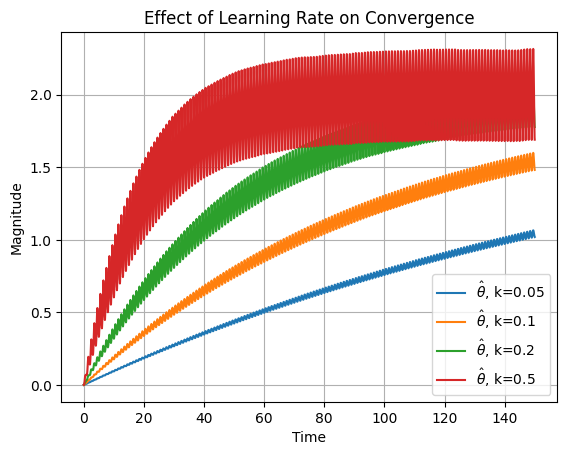

In [134]:
# Time vector 
t = np.linspace(0, 150, 3000)

# Input vector
r1 = a*np.sin(omega*t)
r2 = np.sin(omega*t)
r = np.array([r1,r2])

# Plot the response
plt.figure()

# For each k
for k in [0.05, 0.1, 0.2 , 0.5]:

    # Re-create parameter update block
    gain_sys = ct.tf([k],[1]) # Create a gain block
    update_sys = ct.series(integrator_sys, gain_sys, inputs='y3', outputs='theta_hat')
    
    # Re-create the connected system
    T = ct.interconnect([f_sys, update_sys, modulation_sys, demodulation_sys], inputs=['r1', 'r2'], outputs=['y','theta_hat'])
    
    # Calculate response to input
    response = ct.input_output_response(T, t, r, solve_ivp_method = "Radau")

    plt.plot(response.time, response.outputs[1], label="$\\hat{\\theta}$" + f", k={k}")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.title("Effect of Learning Rate on Convergence")
plt.grid()


The example below compares convergence of the parameter, this time with filtering applied.  

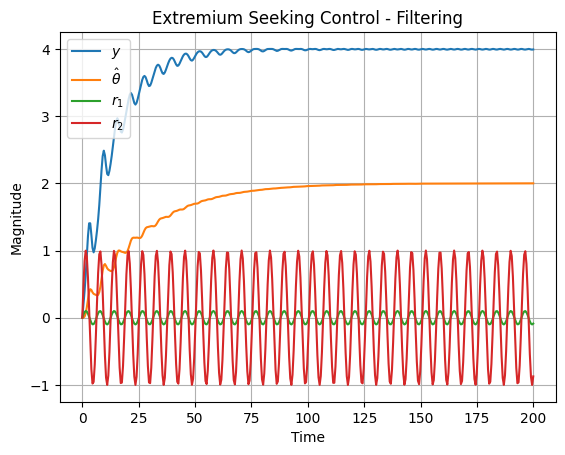

In [136]:
# Parameters 
omega = 1 # Should be within pass-band of both filters
omega_h = 0.5 # High pass filter
omega_l = 2 # Low pass filter
k = 1 # Gain is learning rate
a = 0.1 # Gain on perturbation added to parameter

# Define our function to find the extremium for
def f_upd(t, x, u, params):
    return 0

def f_out(t, x, u, params):
    return 4 - (u[0]-2)**2

# Create our function block
f_sys = ct.nlsys(f_upd, f_out, states='x', inputs='theta', outputs='y')

# Create parameter update block
integrator_sys = ct.tf([1],[1,0]) # Create an integrator
gain_sys = ct.tf([k],[1]) # Create a gain block
lowpass_sys = ct.tf([1],[1,omega_l]) # Create a low pass filter block
update_sys = ct.series(integrator_sys, gain_sys, lowpass_sys, inputs='y3', outputs='theta_hat')

# Create the modulation summing junction
modulation_sys = ct.summing_junction(inputs=['theta_hat', 'r1'], output='theta')

# Create the demodulation block
highpass_sys = ct.tf([1,0],[1,omega_h], inputs=['y'], output='y2') # Create a High pass filter block

def multiply_upd(t, x, u, params):
    return 0
def multiply_out(t, x, u, params):
    return u[0]*u[1]
demodulation_sys = ct.nlsys(multiply_upd, multiply_out, states='x', inputs=['y2', 'r2'], outputs='y3')

d1 = ct.tf([1],[1,0], inputs=['y'], outputs=['theta']) # Create an integrator
d2 = ct.tf([1],[1,0], inputs=['theta'], outputs=['y']) # Create an integrator

T = ct.interconnect([f_sys, update_sys, modulation_sys, highpass_sys, demodulation_sys], inputs=['r1', 'r2'], outputs=['y','theta_hat'])

# Time vector 
t = np.linspace(0, 200, 400)

# Input vector
r1 = a*np.sin(omega*t)
r2 = np.sin(omega*t)
r = np.array([r1,r2])

# Calculate response to input
response = ct.input_output_response(T, t, r)

# Plot the response
plt.figure()
plt.plot(response.time, response.outputs[0], label="$y$")
plt.plot(response.time, response.outputs[1], label="$\\hat{\\theta}$")
plt.plot(response.time, response.inputs[0], label="$r_1$")
plt.plot(response.time, response.inputs[1], label="$r_2$")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.title("Extremium Seeking Control - Filtering")
plt.grid()


The example below shows the effect of filtering on convergence rate, we can see that as we increase reduces the perturbation in the estimated parameter without affecting the convergence rate.

# Applying to a Dynamic Model

We may want to apply extremium seeking control to a plant which has a dynamic model. In this case the phase delay introduced by the plant needs to be taken into account in addition to that of any filters in the de-modulation block.

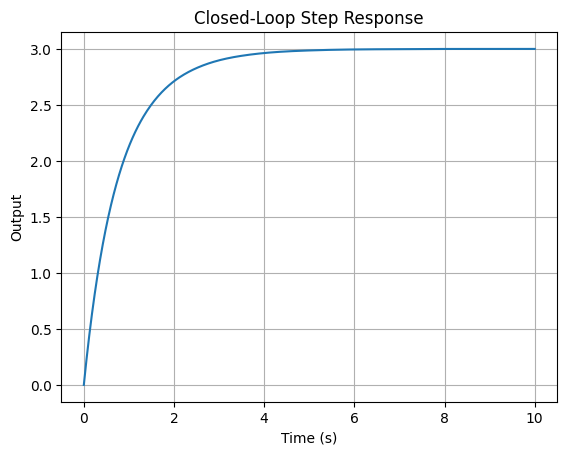

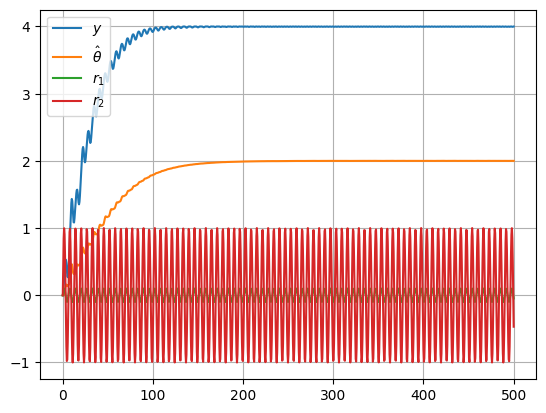

In [5]:
# Define our dynamic function to find the extremium for
def f2_upd(t, x, u, params):
    return -x + u

def f2_out(t, x, u, params):
    return 4 - (x[0]-2)**2

# Create our function block
f2_sys = ct.nlsys(f2_upd, f2_out, states='x', inputs='theta', outputs='y')

# Time vector for simulation
t = np.linspace(0, 10, 500)

# Step response
t_out, y_out = ct.step_response(f2_sys, t)

# Plotting
plt.figure()
plt.plot(t_out, y_out)
plt.title('Closed-Loop Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.grid()
plt.show()

# Define the closed loop system
T = ct.interconnect([f2_sys, update_sys, modulation_sys, highpass_sys, demodulation_sys], inputs=['r1', 'r2'], outputs=['y','theta_hat'])

# Time vector 
t = np.linspace(0, 500, 1000)

# Input vector
r1 = a*np.sin(omega*t)
r2 = np.sin(omega*t)
r = np.array([r1,r2])

# Calculate response to input
response = ct.input_output_response(T, t, r)

# Plot the response
plt.figure()
plt.plot(response.time, response.outputs[0], label="$y$")
plt.plot(response.time, response.outputs[1], label="$\\hat{\\theta}$")
plt.plot(response.time, response.inputs[0], label="$r_1$")
plt.plot(response.time, response.inputs[1], label="$r_2$")
plt.legend()
plt.grid()



# References

[1] Y. Tan, W. H. Moase, C. Manzie, D. Nešić and I. M. Y. Mareels, "Extremum seeking from 1922 to 2010", Proceedings of the 29th Chinese Control Conference, Beijing, China, 2010, pp. 14-26.

[2] K. B. Ariyur, M. Krstic, "Real-Time Optimization by Extremum-Seeking Control". United Kingdom: Wiley, 2003.

[3] R. Leyva, C. Olalla, H. Zazo, C. Cabal, A. Cid-Pastor, I. Queinnec, C. Alonso, "MPPT Based on Sinusoidal Extremum-Seeking Control in PV Generation", International Journal of Photoenergy 2012, 2012, pp. 1–7.

[4] L. Hazeleger, M. Haring, N. van de Wouw, "Extremum-seeking control for optimization of time-varying steady-state responses of nonlinear systems", Automatica, Oxford, England, 2020, vol. 119


